# Mapping Features of Slide-seq to Pixel Images
C. Heiser, July 2019

---
The purpose of this notebook is to generate pixellated images from slide-seq outputs.  
* Slide-seq bead array data is irregularly-spaced, as output from SoLiD sequencing of beads _in situ_ 
* Need to interpolate bead presence by nearest-neighbor gridding to create image of tissue that can be colored by metagene features and used for downstream fusion
* Empty beads outside of tissue area need to be ignored as well; we use a KD Tree to map distances of 'real' beads from one another and threshold on this distance to exclude blank slide area from our image

In [1]:
import sys
sys.path.append('../')
from fcc import *

In [68]:
# reload fcc module while working
del sys.modules['fcc']
from fcc import *

In [8]:
# first, read DGE file and bead locations into `pita` object
# here, the bead locations have already been filtered by DGE indices, but if they aren't, you can run pita.filter_beads()
%time puck_180819_5 = pita.from_file(datafile='../inputs/puck_180819_5_mappedDGE.csv.gz', cells_axis=1, beadfile='../inputs/puck_180819_5_beads_trim.csv', data_type='counts')

CPU times: user 2min 22s, sys: 12 s, total: 2min 34s
Wall time: 2min 39s


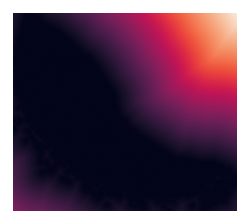

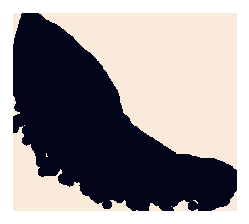

CPU times: user 1min 5s, sys: 1.33 s, total: 1min 6s
Wall time: 1min 6s


In [9]:
%%time
# next, we want to map the beads to pixel-space, then trim the pixels by distance threshold using cKDTree from scipy.spatial
puck_180819_5.map_pixels()
puck_180819_5.trim_pixels(threshold=100)

In [ ]:
%%time 
# now we can perform a PCA on the beads, which represent regions of gene expression patterns in tissue
puck_180819_5.fcc_PCA(data_type='counts', n_components=10, transform='arcsinh')
puck_180819_5.plot(data_type='PCA')

In [ ]:
# to reconstruct an image of the tissue, we can overlay the first principal component (data_type='PCA', feature=0) on our pixel-space
%time PC1 = puck_180819_5.assemble_pita(data_type='PCA', feature=0, plot_out=True)

---
### Build Pita 'Manually'

In [2]:
%time dge = pd.read_csv('../inputs/puck_180819_5_mappedDGE.csv.gz', index_col=0)

CPU times: user 1min 58s, sys: 9.47 s, total: 2min 8s
Wall time: 2min 11s


In [3]:
dge.shape

(20009, 17027)

In [4]:
beads = pd.read_csv('../inputs/puck_180819_5_beads_trim.csv', index_col=0)
beads.sort_values(axis=0, by=['xcoord','ycoord'], inplace=True)

In [5]:
beads.shape

(17027, 2)

In [6]:
%time puck_180819_5_slide = pita(data=dge, bead_locs=beads, cells_axis=1, labels=[0,0], data_type='counts')

CPU times: user 19 s, sys: 1.13 s, total: 20.2 s
Wall time: 20.7 s


In [7]:
%time puck_180819_5_slide.map_pixels()

CPU times: user 31.8 s, sys: 447 ms, total: 32.2 s
Wall time: 32.6 s


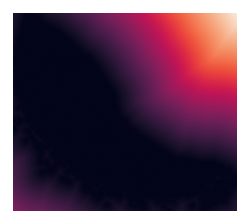

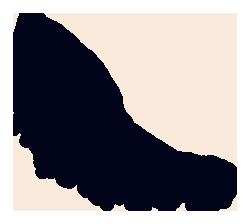

CPU times: user 32.9 s, sys: 839 ms, total: 33.8 s
Wall time: 33.4 s


In [8]:
%time puck_180819_5_slide.trim_pixels(threshold=150)

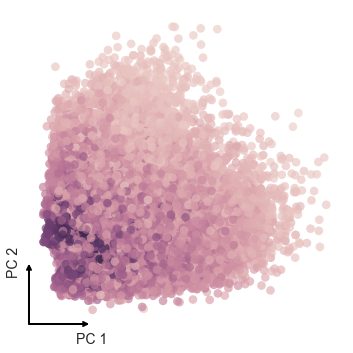

CPU times: user 54.2 s, sys: 23.8 s, total: 1min 18s
Wall time: 1min 24s


In [9]:
%%time 
# now we can perform a PCA on the beads, which represent regions of gene expression patterns in tissue
puck_180819_5_slide.fcc_PCA(data_type='counts', n_components=10, transform='arcsinh')
puck_180819_5_slide.plot(data_type='PCA')

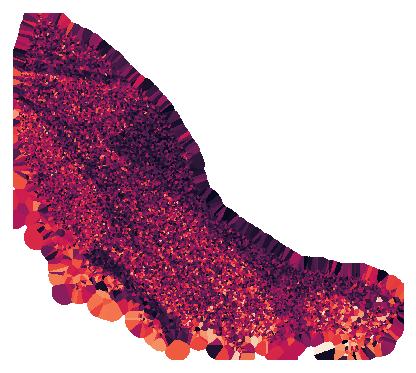

CPU times: user 5.53 s, sys: 773 ms, total: 6.3 s
Wall time: 6.52 s


In [10]:
# to reconstruct an image of the tissue, we can overlay the first principal component (data_type='PCA', feature=0) on our pixel-space
%time PC1 = puck_180819_5_slide.assemble_pita(data_type='PCA', feature=0, plot_out=True)

Maybe we didn't trim enough. Let's try a stricter threshold:

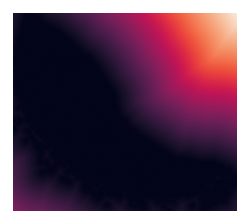

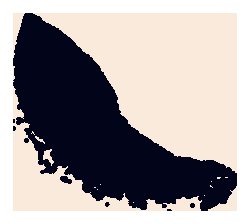

CPU times: user 33 s, sys: 751 ms, total: 33.7 s
Wall time: 33.5 s


In [15]:
%%time
puck_180819_5_slide.trim_pixels(threshold=50)

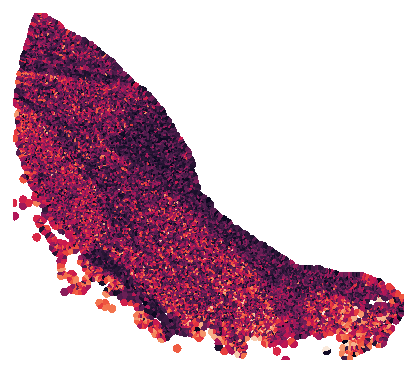

CPU times: user 5.86 s, sys: 646 ms, total: 6.5 s
Wall time: 6.58 s


In [16]:
# to reconstruct an image of the tissue, we can overlay the first principal component (data_type='PCA', feature=0) on our pixel-space
%time PC1 = puck_180819_5_slide.assemble_pita(data_type='PCA', feature=0, plot_out=True)

---
### __Example 2:__ Read cerebellum dataset to `pita` object

In [17]:
%time cerebellum_slide = pita.from_file(datafile='../inputs/cerebellum_slice_rna.csv.gz', beadfile='../inputs/cerebellum_slice_beads.csv.gz', data_type='counts')

CPU times: user 50.6 s, sys: 3.23 s, total: 53.8 s
Wall time: 54.3 s


Create pixel map for cerebellum dataset to create images from

In [18]:
%time cerebellum_slide.map_pixels()

CPU times: user 2.53 s, sys: 61.5 ms, total: 2.59 s
Wall time: 2.63 s


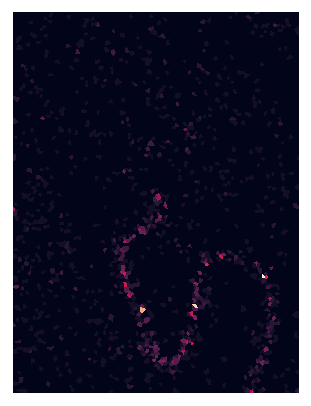

CPU times: user 1.16 s, sys: 49.1 ms, total: 1.21 s
Wall time: 1.12 s


In [20]:
%time aldoc = cerebellum_slide.assemble_pita(data_type='counts', feature='Aldoc', plot_out=True, trimmed=False)

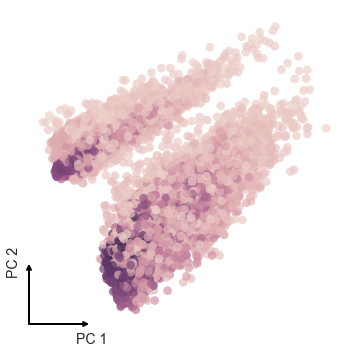

CPU times: user 18.9 s, sys: 3.71 s, total: 22.6 s
Wall time: 20.1 s


In [21]:
%%time 
cerebellum_slide.fcc_PCA(data_type='counts', n_components=10, transform='arcsinh')
cerebellum_slide.plot(data_type='PCA')

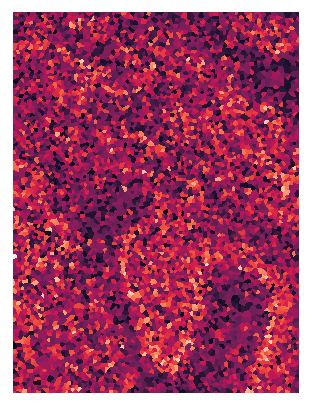

In [22]:
PC1 = cerebellum_slide.assemble_pita(data_type='PCA', feature=0, plot_out=True, trimmed=False)

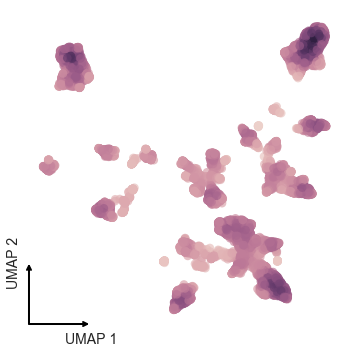

CPU times: user 26.6 s, sys: 1.21 s, total: 27.8 s
Wall time: 28.3 s


In [23]:
%%time 
cerebellum_slide.fcc_UMAP(data_type='PCA', perplexity=30, seed=18)
cerebellum_slide.plot(data_type='UMAP')

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17b914390>)

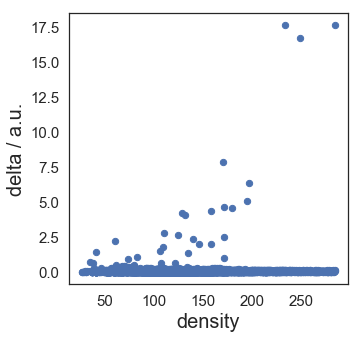

In [24]:
cerebellum_slide.clu['UMAP'].draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1445b54a8>)

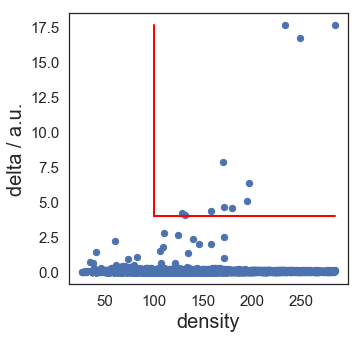

In [25]:
cerebellum_slide.clu['UMAP'].assign(100,4)
cerebellum_slide.clu['UMAP'].draw_decision_graph(min_density=cerebellum_slide.clu['UMAP'].min_density, min_delta=cerebellum_slide.clu['UMAP'].min_delta)

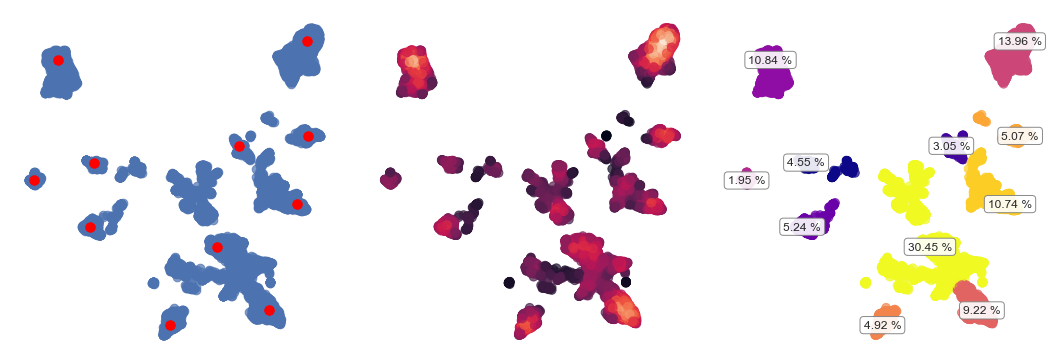

In [26]:
cerebellum_slide.plot_clusters(data_type='UMAP')

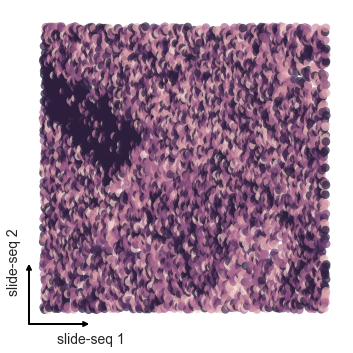

In [27]:
cerebellum_slide.plot(data_type='slide-seq', color=cerebellum_slide.clu['UMAP'].membership)